In [1]:
import json
import itertools
import os
import pandas as pd
from matplotlib import pyplot as plt
from IPython.core.display import HTML
import subprocess

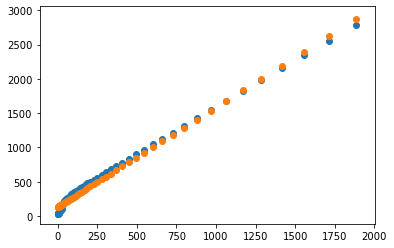

In [2]:
os.system("g++ -ffast-math -march=native -O3 measure_linvbin.cpp")
os.system("./a.out > bvl.csv")

df = pd.read_csv("bvl.csv", header=None, names=["method", "err", "time"])
df["time"] /= 500000


from scipy.stats import linregress
x = df[df.method == "linear"]["err"]
y = df[df.method == "linear"]["time"]

lslope, lintercept, lrval, _, _ = linregress(x, y)
def lin_mod(x):
    return (lslope * x + lintercept).clip(lower=0)

assert lrval > 0.98

plt.scatter(x, y)
plt.scatter(x, lin_mod(x))

0.9969939318397829


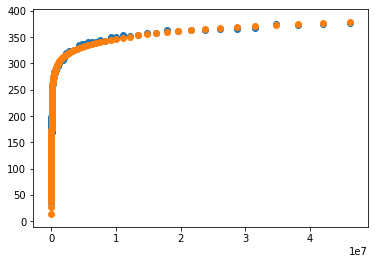

In [3]:
import numpy as np
x = df[df.method == "binary"]["err"]
y = df[df.method == "binary"]["time"]
slope, intercept, rval, _, _ = linregress(np.log(x), y)
print(rval)
def bin_mod(x):
    return (np.log(x) * slope + intercept).clip(lower=0)

plt.scatter(x, y)
plt.scatter(x, bin_mod(x))

In [4]:
from sklearn.neighbors import KNeighborsRegressor

bin_pred = KNeighborsRegressor(n_neighbors=2)
bin_pred.fit(df[df.method == "binary"][["err"]], df[df.method == "binary"]["time"])

lin_pred = KNeighborsRegressor(n_neighbors=2)
lin_pred.fit(df[df.method == "linear"][["err"]], df[df.method == "linear"]["time"])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [5]:
lin_pred.predict([[1]])
bin_pred.predict([[1]])

array([37.093124])

In [6]:
DATA_PATH = "/home/ryan/SOSD/data/osm_cellids_200M_uint64"
DATA_FILE = DATA_PATH.split("/")[-1]

os.system("cd .. && cargo build --release")
RMI_PATH = "../target/release/rmi"

In [7]:
top_only_layers = ["radix", "bradix"]
anywhere_layers = ["linear", "cubic"]
specialty_top_layers = ["histogram", "loglinear", "normal", "lognormal"]
branching_factors = [2**x for x in range(7, 22)]

In [8]:
all_top_layers = top_only_layers + anywhere_layers

In [9]:
# first, build a grid of the most likely configs
configs = []
nmspc_counter = 0
for top in all_top_layers:
    for bot in anywhere_layers:
        for bf in branching_factors[::3]:
            configs.append({"layers": f"{top},{bot}", "branching factor": bf, "namespace": f"nm{nmspc_counter}"})
            nmspc_counter += 1
            
# next, build a few tests to see if a speciality layer would help
for top in specialty_top_layers:
    if top == "histogram":
        for bot in anywhere_layers:
            for bf in [64, 128, 256]:
                configs.append({"layers": f"{top},{bot}", "branching factor": bf, "namespace": f"nm{nmspc_counter}"})
                nmspc_counter += 1
    else:
        # not a histogram
        for bot in anywhere_layers:
            for bf in branching_factors[::4]:
                configs.append({"layers": f"{top},{bot}", "branching factor": bf, "namespace": f"nm{nmspc_counter}"})
                nmspc_counter += 1


In [10]:
def parallel_test_rmis(configs, threads=8, phase="", fast_top=False):
    if len(configs) < threads:
        threads = len(configs)
        
    os.system("rm *.json *.json_results")
    jobs = [[] for _ in range(threads)]
    procs = []
    
    for idx, conf in enumerate(configs):
        jobs[idx % threads].append(conf)
        
    for idx, workset in enumerate(jobs):
        fn = f"{phase}{idx}.json"
        with open(fn, "w") as f:
            json.dump({"configs": workset}, f)
        cmd = f"{RMI_PATH} {DATA_PATH} --param-grid {fn}"
        if fast_top:
            cmd += " --fast-top"
            
        procs.append(subprocess.Popen(cmd, shell=True))

    print("Spawned", threads, "processes with", [len(x) for x in jobs], "jobs each")
    
    for proc in procs:
        proc.wait()
        
    os.system("sync")
    os.system("rm -rf opt/")
    os.system("mkdir opt")
    os.system("mv nm* opt/")
    data = []
    for idx, _ in enumerate(jobs):
        fn = f"{phase}{idx}.json_results"
        with open(fn, "r") as f:
            data.extend(json.load(f))

    return data
    

In [11]:
print("Testing", len(configs), "initial configurations.")

step1_results = parallel_test_rmis(configs, phase="step1", fast_top=True)
step1_results = pd.DataFrame(step1_results)

Testing 70 initial configurations.
Spawned 8 processes with [9, 9, 9, 9, 9, 9, 8, 8] jobs each


KeyboardInterrupt: 

In [ ]:
display(HTML(step1_results.to_html()))

In [ ]:
import pystache
with open("bench.cpp", "r") as f:
    template = f.read()
    
with open("to_build.cpp", "w") as f:
    f.write(pystache.render(template, 
                            {"filename": DATA_PATH, 
                             "namespaces": step1_results.namespace.tolist()}))
    
if os.system("make -j 40") != 0:
    print("Error compiling inference program!")
    
os.system("./a.out > inference.txt")
with open("inference.txt") as f:
    inference = list(int(x.strip()[:-2]) / 100000.0 for x in f)
    
step1_results["inference"] = inference

In [ ]:
step1_results["pred_time_lin"] = step1_results.inference + lin_pred.predict(step1_results[["max error"]])
step1_results["pred_time_bin"] = step1_results.inference + bin_pred.predict(step1_results[["max error"]])
step1_results["pred_time"] = step1_results[["pred_time_lin", "pred_time_bin"]].min(axis=1)
step1_results

In [ ]:
def pareto_mask(df, v1="size linear search", v2="pred_time", soft=True):
    # find Pareto efficient RMIs
    mask = []
    for idx1, el1 in df.iterrows():
        my_size = el1[v1]
        my_time = el1[v2]
        for idx2, el2 in df.iterrows():
            if idx1 == idx2:
                continue

            if ((el2[v1] <= my_size) 
                and (el2[v2] <= my_time - (5 if soft else 0))):
                mask.append(False)
                break
        else:
            mask.append(True)
    return mask

In [ ]:
mask = pareto_mask(step1_results)
pareto = step1_results[mask]
print("Found", len(pareto), "Pareto efficient models")
display(HTML(pareto.to_html()))

In [ ]:
candidate_layers = set(pareto["layers"])
next_configs = []
for candidate in candidate_layers:
    if candidate.startswith("histogram"):
        for bf in [32, 300, 512]:
            next_configs.append({"layers": candidate, "branching factor": bf,
                                 "namespace": f"nm{nmspc_counter}"})
            nmspc_counter += 1

    else:
        already_known = step1_results[step1_results.layers == candidate]["branching factor"].to_list()
        for bf in sorted(set(branching_factors) - set(already_known)):
            next_configs.append({"layers": candidate, "branching factor": bf,
                                 "namespace": f"nm{nmspc_counter}"})
            nmspc_counter += 1

In [ ]:
print("Testing", len(next_configs), "additional configurations.")

step2_results = parallel_test_rmis(next_configs, phase="step2", fast_top=True)
step2_results = pd.DataFrame(step2_results)

In [ ]:
import pystache
with open("bench.cpp", "r") as f:
    template = f.read()
    
with open("to_build.cpp", "w") as f:
    f.write(pystache.render(template, 
                            {"filename": DATA_PATH, 
                             "namespaces": step2_results.namespace.tolist()}))
    

In [ ]:
print("Compiling...")
os.system("make -j 40")

print("Executing...")
os.system("./a.out > inference.txt")
with open("inference.txt") as f:
    inference = list(int(x.strip()[:-2]) / 100000.0 for x in f)
    
step2_results["inference"] = inference

In [ ]:
step2_results["pred_time_lin"] = step2_results.inference + lin_pred.predict(step2_results[["max error"]])
step2_results["pred_time_bin"] = step2_results.inference + bin_pred.predict(step2_results[["max error"]])
step2_results["pred_time"] = step2_results[["pred_time_lin", "pred_time_bin"]].min(axis=1)
step2_results

In [ ]:
all_results = pd.concat((step1_results, step2_results)).reset_index(drop=True)
mask = pareto_mask(all_results)
all_results.sort_values("pred_time")

In [ ]:
display(HTML(all_results.sort_values("pred_time").to_html()))

In [ ]:
def human_size(bytes, units=[' bytes','KB','MB','GB','TB', 'PB', 'EB']):
    """ Returns a human readable string reprentation of bytes"""
    return str(bytes) + units[0] if bytes < 1024 else human_size(bytes>>10, units[1:])

all_hresults = all_results.copy()
all_hresults["size linear search"] = [human_size(x) for x in all_results["size linear search"].to_list()]
all_hresults["size binary search"] = [human_size(x) for x in all_results["size binary search"].to_list()]
all_hresults[mask].sort_values("pred_time")

In [ ]:
ax = all_results.plot.scatter("size binary search", "pred_time", color="orange")
all_results[mask].plot.scatter("size binary search", "pred_time", ax=ax)

In [ ]:
all_results["binary"] = all_results["pred_time_lin"] >= all_results["pred_time_bin"]

final_configs = []
for idx, row in all_results[mask][["layers", "branching factor", "namespace", "binary"]].iterrows():
    final_configs.append(row.to_dict())
                         
final_results = parallel_test_rmis(final_configs, phase="step3")

In [ ]:
os.system("rm -rf SOSD/competitors/rmi/nm*")
for idx, r in all_results[mask].iterrows():
    ns = r["namespace"]
    os.system(f"cp opt/{ns}.cpp SOSD/competitors/rmi/")
    os.system(f"cp opt/{ns}_data.h SOSD/competitors/rmi/")
    os.system(f"cp opt/{ns}.h SOSD/competitors/rmi/")

In [ ]:
with open("SOSD/benchmark.cc.mustache", "r") as f:
    template = f.read()
    
with open("SOSD/benchmark.cc", "w") as f:
    f.write(pystache.render(template, 
                            {"candidates": final_configs}))
    
os.system("cd SOSD && scripts/prepare.sh")
os.system(f"cd SOSD && build/benchmark {DATA_PATH} {DATA_PATH}_equality_lookups_10M > times.txt")

In [ ]:
times = []
with open("SOSD/times.txt", "r") as f:
    for l in f:
        if not l.startswith("RESULT"):
            continue
        if "," not in l:
            continue
        result = l.split(",")[1]
        if result == "-1":
            times.append(float("NaN"))
        else:
            times.append(float(result))
        
tested_results = all_results[mask].copy()
tested_results["measured"] = times
tested_results.plot.scatter("pred_time", "measured")

In [ ]:
failed_mask = tested_results["measured"].isna()
tested_results[failed_mask][["layers", "branching factor"]]

In [ ]:
final_mask = pareto_mask(tested_results, v2="measured", soft=False)
tested_results[final_mask].plot.scatter("size linear search", "measured")
tested_results[final_mask].sort_values("measured")